In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Optimisation with Stochastic Gradient Descent

The reaction rates of the circuits can be directly optimised with the automatic differentiation provided by jax

In [49]:
from datetime import datetime 
import jax 
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optax
from scipy.special import factorial
import diffrax as dfx
from functools import partial
from bioreaction.misc.misc import flatten_listlike
from synbio_morpher.utils.results.analytics.timeseries import get_sensitivity, get_precision, get_peaks

jax.config.update('jax_platform_name', 'gpu')

rng = jax.random.PRNGKey(0)

np.random.seed(0)


In [50]:
def processor(input, funcs):
    for func in funcs:
        if type(input) == tuple:
            input = func(*input)
        else:
            input = func(input)
    return input


In [55]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


# ODE Terms
def bioreaction_sim_expanded(t, y,
                             args,
                             inputs, outputs,
                             #  signal, signal_onehot: jnp.ndarray,
                             forward_rates=None, reverse_rates=None):
    return one_step_de_sim_expanded(
        spec_conc=y, inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates)  # + signal(t) * signal_onehot


def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5,
                                 stepsize_controller=dfx.ConstantStepSize()):
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates.squeeze(), reverse_rates=reverse_rates.squeeze()
                )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=dt0,
                           y0=y0.squeeze(),
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=stepsize_controller)


def f(reverse_rates, y0, t0, t1, dt0,
      inputs, outputs, forward_rates):
    s = bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                     inputs, outputs, forward_rates, reverse_rates,
                                     saveat=dfx.SaveAt(ts=np.linspace(t0, t1, 100)))
    ys = s.ys
    # ys = s.ys[:np.argmax(s.ts >= np.inf), :]
    # ts = s.ts[:np.argmax(s.ts >= np.inf)]

    return ys


def f2(eqconstants_exps, y0, t0, t1, dt0,
       inputs, outputs, forward_rates):
    
    eqconstants = jnp.power(10, eqconstants_exps)
    reverse_rates = forward_rates / eqconstants
    s = bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                     inputs, outputs, forward_rates, reverse_rates,
                                     saveat=dfx.SaveAt(ts=np.linspace(t0, t1, 100)))
    ys = s.ys
    return ys


def cost_f(ys, signal_idx, output_idxs):
    peaks = get_peaks(ys[0, :], ys[-1, :], jnp.max(ys, axis=0), jnp.min(ys, axis=0))
    sens = get_sensitivity(signal_idx=signal_idx,
                           starting_states=ys[0, :], peaks=peaks)
    cost = -jnp.prod(sens[output_idxs])
    return cost

## Define parameters

Creating a toy (RNA) circuit. The $k_1$ is the association binding rate (molecule / sec) for RNA binding, expanded for every binding reaction into `forward_rates`, and is assumed to be the same for all RNA. The equilibrium constants are randomly generated and define the circuit. From this and $k_1$, the reverse rate is calculated.

In [56]:
n_species = 3
n_circuits = 100
n_reactions = np.sum(np.arange(n_species+1))
tot_species = n_species + n_reactions

signal_idxs = np.array([0])
output_idxs = np.array([1, 2])
signal_onehot = np.zeros(tot_species)
signal_onehot[signal_idxs] = 1
signal_target = 2

y0 = np.array([200.0] * n_species + [0.0] * n_reactions) 
k1 = 0.00150958097
t0, t1, dt0 = 0, 20, 0.001

inputs, outputs = np.zeros((n_reactions, tot_species)), np.zeros(
    (n_reactions, tot_species))
inds = flatten_listlike([[(i, j) for j in range(i, n_species)]
                        for i in range(n_species)])

for i in range(n_reactions):
    inputs[i, inds[i][0]] += 1
    inputs[i, inds[i][1]] += 1
    outputs[i, i+n_species] += 1
    
forward_rates = np.ones(n_reactions) * k1
# eqconstants = np.power(10, np.random.normal(0, 1, (n_circuits, n_reactions)))
eqconstants_exps = (np.random.rand(n_circuits, n_reactions) - 0.5) * 5
eqconstants = np.power(10, eqconstants_exps)
reverse_rates = k1 / eqconstants


### Steady states + perturbation

Run the simulation once with starting states for the RNA molecules and their bound-together states. Use the steady states from that as the starting states for the optimisation simulation. Because we are (for now) trying to optimise for circuits that are very sensitive to a signal, we can perturb these starting states with a signal.

In [57]:
def f_simstep(circuit_params, y0, f, signal_onehot, signal_target):
    y_steady = f(circuit_params, y0)
    y_perturbed = y_steady[-1, :] * (signal_onehot == 0) + \
        y_steady[-1, :] * (signal_onehot == 1) * signal_target
    return y_steady, y_perturbed


def sim_wrapper(circuit_params, yp, y0, f_t):
    ys = f_t(circuit_params, yp)
    return jnp.concatenate([y0, ys], axis=0)


f_t = partial(f2, t0=t0, t1=t1, dt0=dt0, inputs=inputs,
              outputs=outputs, forward_rates=forward_rates)
f_simstep_t = partial(
    f_simstep, f=f_t, signal_onehot=signal_onehot, signal_target=signal_target)
c_t = partial(cost_f, signal_idx=signal_idxs, output_idxs=output_idxs)
sim_chain = [partial(sim_wrapper, f_t=f_t), c_t]
f_full = partial(processor, funcs=sim_chain)

y_steady, y_perturbed = jax.vmap(f_simstep_t)(
    eqconstants_exps, y0=np.repeat(y0[None, :], repeats=n_circuits, axis=0))

In [58]:
y_steady[:10].max(axis=1).shape

(10, 9)

<Axes: >

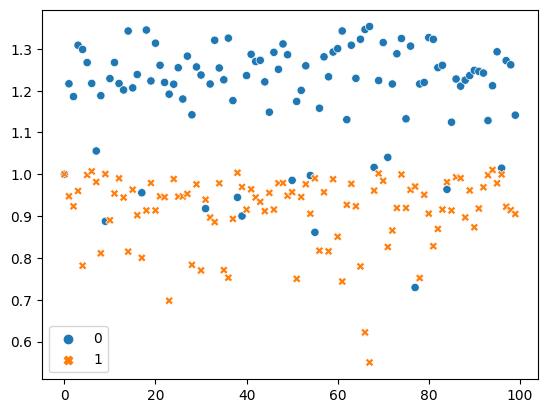

In [59]:
sns.scatterplot(get_sensitivity(signal_idx=signal_idxs, starting_states=y_steady[:, 1, :], peaks=get_peaks(y_steady[:, 0, :], y_steady[:, -1, :], y_steady.max(axis=1), y_steady.min(axis=1)))[:, output_idxs])

In [60]:
# Test it
cost = jax.vmap(f_full)((eqconstants_exps, y_perturbed, y_steady[:, -1, :][:, None, :]))
cost


Array([-1.20754391e-01, -1.47448145e-02, -3.05155553e-02, -1.65332720e-01,
       -9.66839376e-04, -1.41752392e-01, -3.16368610e-01, -1.96026601e-02,
       -4.75264946e-03, -6.72837533e-03, -1.03393504e-02, -2.53657307e-02,
       -1.26633272e-01, -1.41532823e-01, -2.92850167e-01, -1.37193985e-02,
       -5.92239760e-02, -1.15258712e-02, -1.88356295e-01, -5.77174760e-02,
       -5.78850769e-02, -7.54187349e-03, -2.57661287e-02, -1.71851609e-02,
       -1.17706701e-01, -5.56529276e-02, -1.50656216e-02, -5.61988875e-02,
       -3.16766345e-05, -6.65439591e-02, -6.66607544e-02, -1.80437937e-02,
       -9.51262470e-03, -6.20690770e-02, -2.78587807e-02, -1.58422571e-02,
       -9.86407921e-02, -2.79718526e-02, -2.35913228e-02, -8.61968671e-04,
       -6.72943741e-02, -9.04920101e-02, -2.57825673e-01, -3.54268812e-02,
       -1.58424918e-02, -5.32777840e-03, -2.33064387e-02, -2.86370125e-02,
       -1.97508618e-01, -2.44836174e-02, -5.48211634e-02, -9.62263048e-02,
       -1.59939993e-02, -

# Simulate

Optimiser and learning rate management

In [38]:
l2_reg_alpha = 0.1
learning_rate = 0.001
warmup_epochs = 5
epochs = 100
n_batches = 1
warmup_fn = optax.linear_schedule(
    init_value=0., end_value=learning_rate,
    transition_steps=warmup_epochs * n_batches)
cosine_epochs = max(epochs - warmup_epochs, 1)
cosine_fn = optax.cosine_decay_schedule(
    init_value=0.01, decay_steps=1000) #, alpha=l2_reg_alpha)
schedule_fn = optax.join_schedules(
    schedules=[warmup_fn, cosine_fn],
    boundaries=[warmup_epochs * n_batches])
optimiser = optax.sgd(learning_rate=schedule_fn)
optimiser_state = optimiser.init(reverse_rates[0])

Core function to iterate over. The automatic differentiation is enacted by the function `jax.value_and_grad` and can only evaluate a function that returns a scalar input. In order to do this for all of our samples, we can wrap it in the vectorisation function `jax.vmap`. The inputs are then the parameters of the circuit (either the equilibrium constant or the reverse rates, depending on what we're testing), along with the previously computed starting states (`y_steady_states`) and the perturbed signal state (`y_perturbed`). We need both in order to calculate the sensitivity after simulating the time series for all of our circuits, from which we calculate the cost function. Unfortunately, we can't vmap these two input parameters because they differ for each circuit. The updates are then applied to the circuit parameters with the `optax` library. 

In [43]:
def f_scan(inp, cr, f, fsim, y0):
    c, r = cr
    circuit_params, optimiser_state = inp
    
    y0, yp = jax.vmap(fsim)(circuit_params, y0)
    y0 = y0[:, -1, :][:, None, :]
    
    c, grads = jax.vmap(jax.value_and_grad(f, argnums=0))((circuit_params, yp, y0))
    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    
    new_circuit_params = optax.apply_updates(circuit_params, updates[0])
    # Slow down gradient if negatives appear
    new_circuit_params = jnp.where(new_circuit_params <= 0, optax.apply_updates(circuit_params, 0.01 * updates[0]), new_circuit_params)
    circuit_params = jnp.where(new_circuit_params <= 0, circuit_params / 10, new_circuit_params)
    return [circuit_params, optimiser_state], [c, circuit_params]

cs = np.zeros([epochs, n_circuits])
rs = np.zeros([epochs, *eqconstants.shape])

### Run simulation

In [44]:
# 3 mins
print('Predicted time:', 17.5/30 * epochs, 'mins')

start_time = datetime.now()
ro, crs = jax.lax.scan(partial(f_scan, f=f_full, fsim=f_simstep_t,
                       y0=y_steady[:, -1, :][:, None, :]), init=[eqconstants_exps, optimiser_state], xs=[cs, rs])
print('Time:', datetime.now() - start_time)

all_eqconstants = np.concatenate([eqconstants_exps[None, :, :], np.zeros_like(rs)])
fin_eqconstants, optimiser_state = ro
cs, all_eqconstants1 = crs
all_eqconstants[1:] = all_eqconstants1

Predicted time: 1.75 mins
Time: 0:01:48.070994


Costs over all epochs:

In [45]:
cs

Array([[-3.90969366e-02, -3.53209823e-02, -1.57227460e-02,
        -6.40742630e-02, -1.98031828e-01, -4.38055634e-01,
        -4.01895726e-03, -5.32818306e-03, -3.22792456e-02,
        -1.67586934e-02, -1.74972396e-02, -7.77022727e-03,
        -5.59123419e-03, -1.66839987e-01, -1.92327071e-02,
        -1.36438953e-02, -9.49333608e-03, -6.58281520e-02,
        -6.60107657e-02, -8.89638215e-02, -3.32256630e-02,
        -5.14997132e-02, -1.52321547e-01, -2.41811816e-02,
        -1.75767377e-01, -2.26248696e-01, -1.20166130e-02,
        -7.23835826e-02, -1.58389974e-02, -6.51244521e-02,
        -1.20675057e-01, -7.19890406e-04, -2.75692753e-02,
        -5.92345558e-02, -2.83637613e-01, -3.98043618e-02,
        -2.00705230e-01, -4.01700139e-02, -3.03775948e-02,
        -2.54565813e-02, -3.42622795e-03, -2.65523009e-02,
        -7.82857742e-03, -1.24487160e-02, -1.96125001e-01,
        -1.99740157e-02, -2.57398980e-03, -3.34534212e-03,
        -2.46066768e-02, -2.80285571e-02, -3.72970663e-0

Circuit parameters over all epochs:

In [46]:
np.power(10, all_eqconstants[-1])

array([[1.75414956e+00, 1.19109621e+01, 3.26450181e+00, 1.67655241e+00,
        4.15346742e-01, 5.36377525e+00],
       [4.87415850e-01, 9.09630508e+01, 2.08119995e+02, 2.61728644e-01,
        2.87491627e+01, 1.39468503e+00],
       [2.18888378e+00, 1.34271301e+02, 7.13445572e-03, 1.22436322e-02,
        4.44853213e-03, 4.60361748e+01],
       [2.45914288e+01, 7.08044815e+01, 2.47224609e+02, 3.13179131e+01,
        6.41881227e-01, 2.52723656e+01],
       [8.71429779e-03, 5.00731754e+00, 2.15686634e-02, 1.67241699e+02,
        1.28601873e+00, 3.74516040e-01],
       [6.57090619e-02, 2.35054436e+01, 6.03633583e-01, 2.19872856e+00,
        1.56256126e-03, 3.87416244e+00],
       [3.63478398e+00, 3.84299636e+00, 1.65478043e+02, 8.11150646e+00,
        1.98488548e-01, 4.84360218e-01],
       [9.73096657e+00, 6.24410529e-03, 6.82077265e+00, 7.13163900e+00,
        3.55636254e-02, 1.36665087e-02],
       [1.19369805e-01, 2.08374724e-01, 2.24379849e+00, 4.93237376e-01,
        2.76610840e+02, 

# Visualise

Let's see what kind of behavior the trained network is now giving us:

Exception ignored in: <function _xla_gc_callback at 0x7f9c78183910>
Traceback (most recent call last):
  File "/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


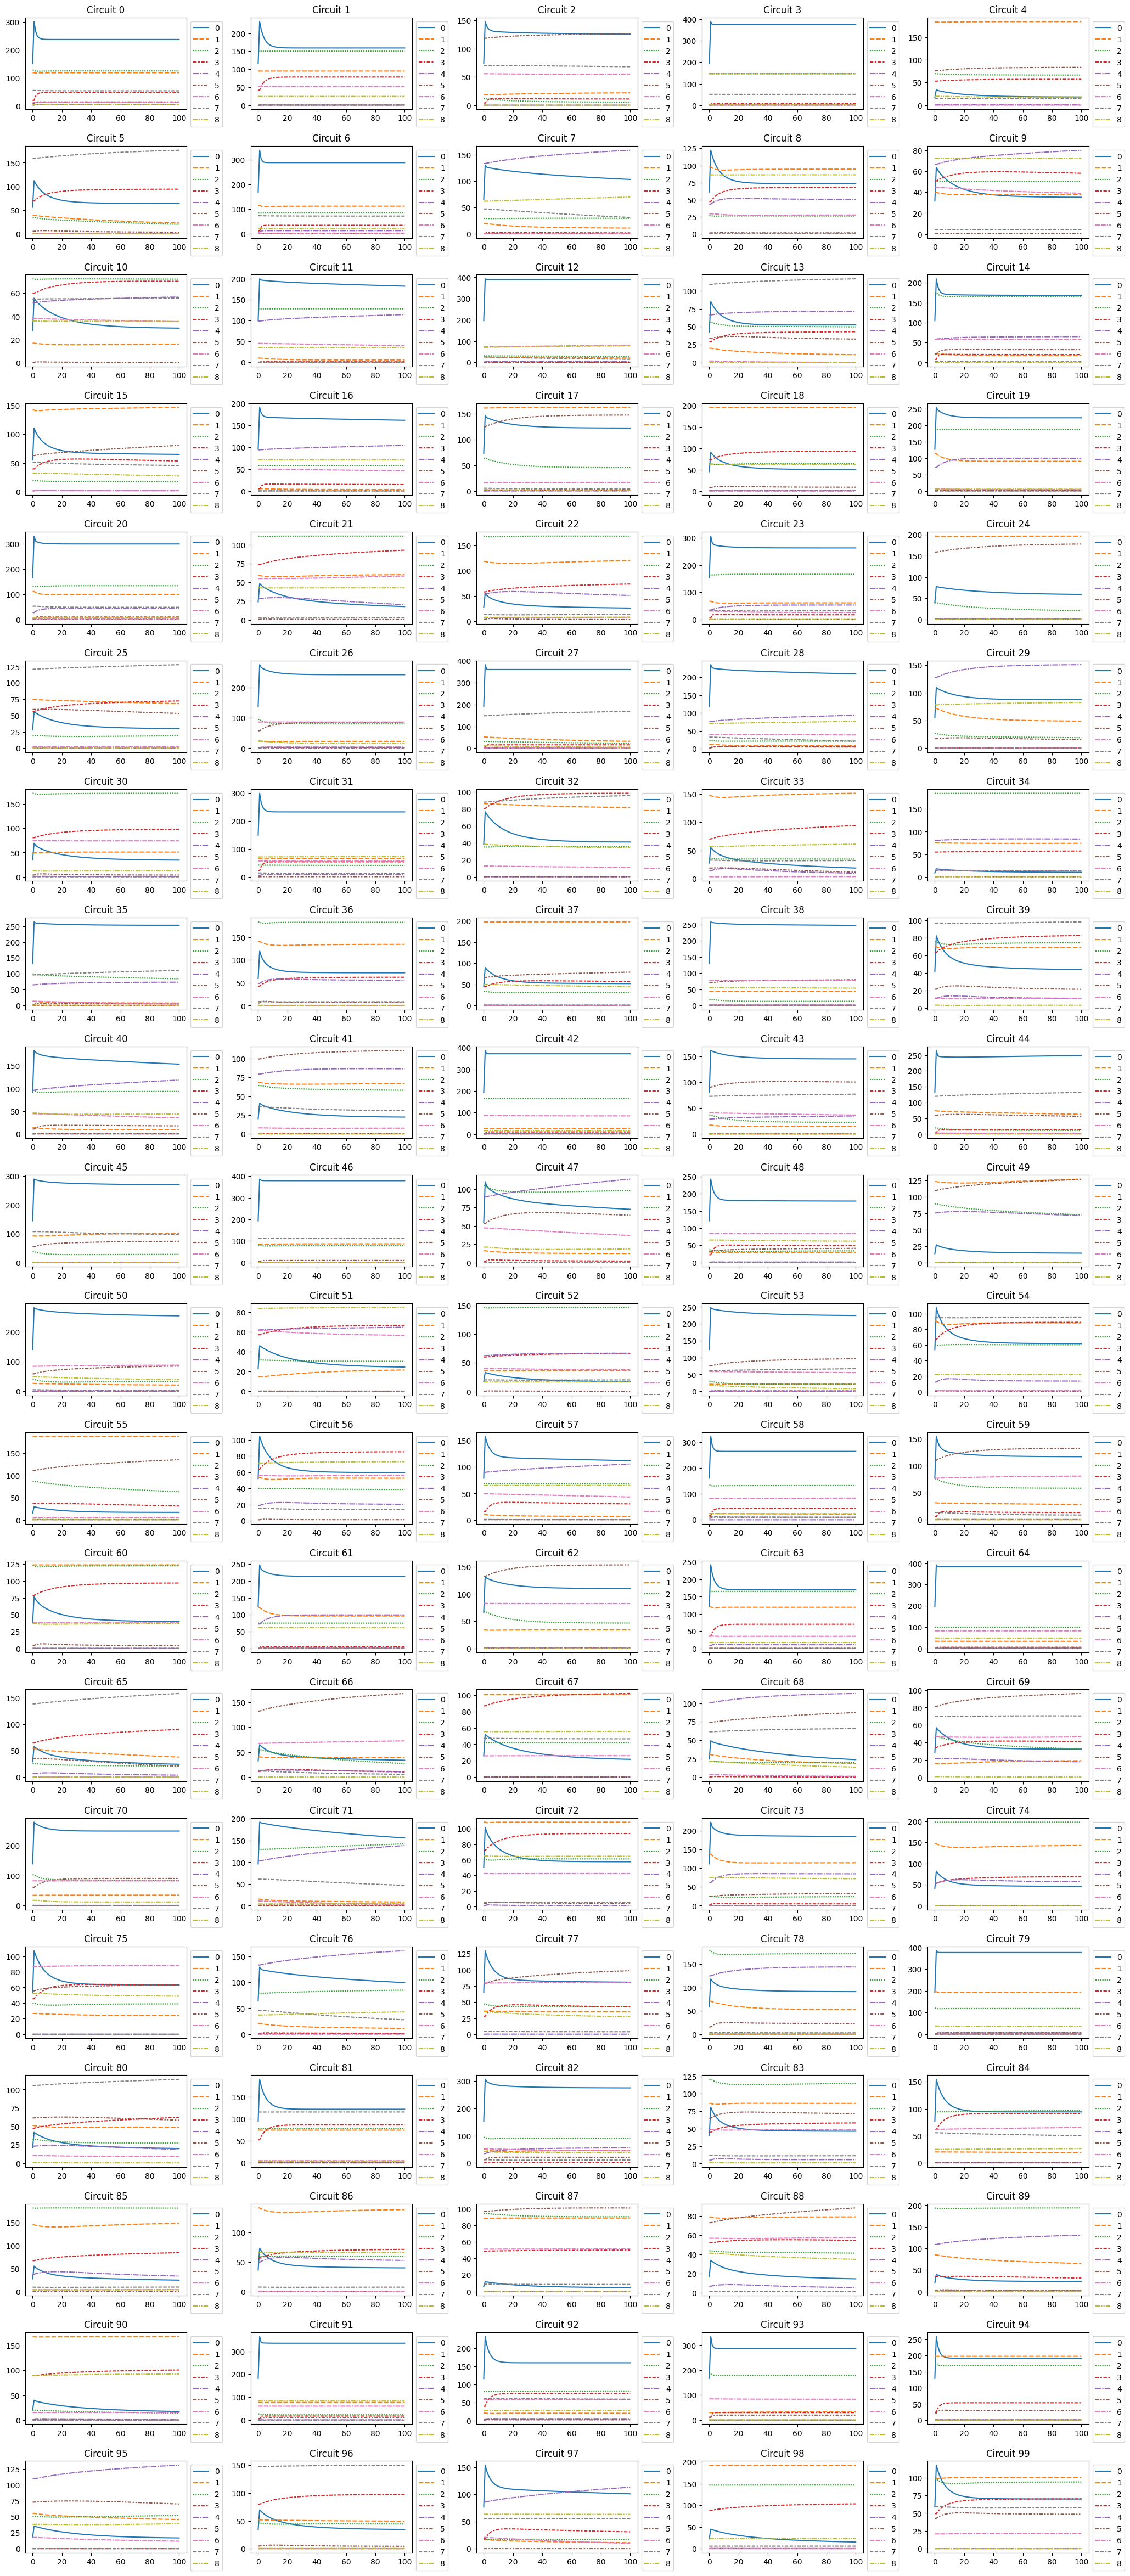

In [47]:
# ys = jax.vmap(f_t)(k1 / all_eqconstants[-1], y0=y_perturbed)
ys = jax.vmap(sim_chain[0])(k1 / np.power(10, all_eqconstants[-1]), yp=y_perturbed, y0=y_steady[:, -1, :][:, None, :])
n_rows = n_circuits // 5 + (np.mod(n_circuits, 5) != 0)
n_cols = n_circuits // n_rows
fig = plt.figure(figsize=(5*n_cols, 3 * n_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for c, y in enumerate(ys):
    ax = plt.subplot(n_rows, n_cols, c+1)
    g = sns.lineplot(y, ax=ax)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Circuit {c}')

## Circuit param evolution

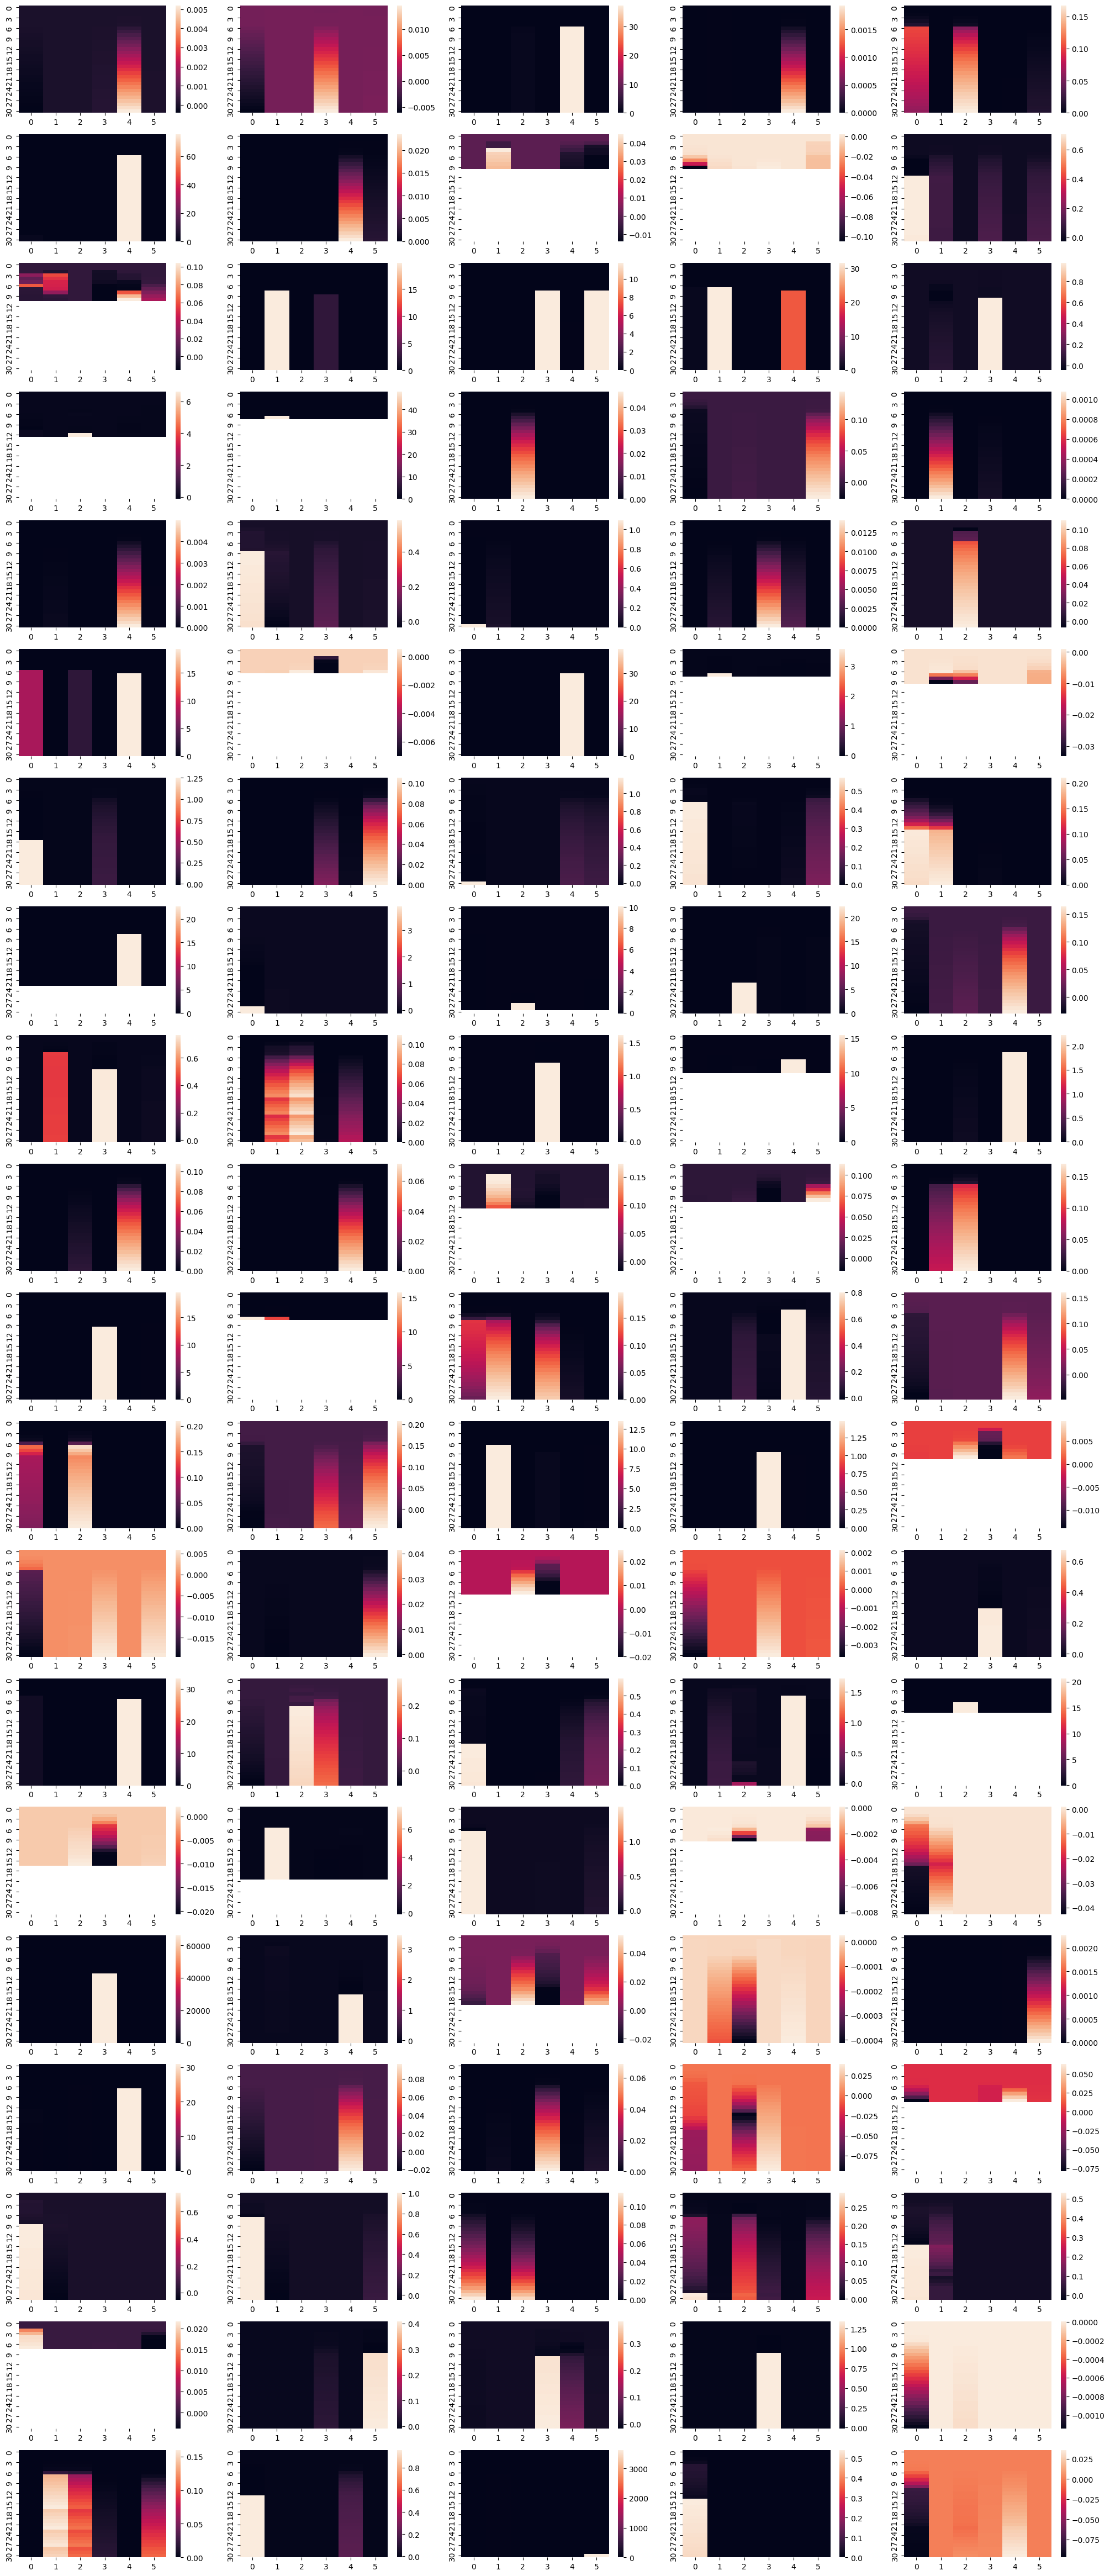

In [168]:
n_rows = n_circuits // 5 + (np.mod(n_circuits, 5) != 0)
n_cols = n_circuits // n_rows
fig = plt.figure(figsize=(5*n_cols, 3 * n_rows))
for c in range(n_circuits):
    ax = plt.subplot(n_rows, n_cols, c+1)
    sns.heatmap(all_eqconstants[:, c, :]) # - all_eqconstants[0, c, :])

## Costs

<Axes: >

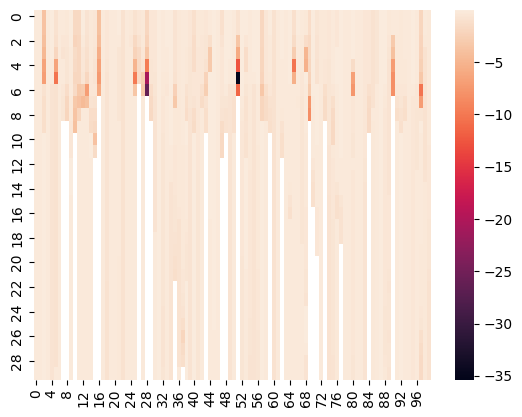

In [169]:
sns.heatmap(cs)

# Unpacked scan (for loop)

In [170]:
# cs = np.zeros([epochs, n_circuits])
# rs = np.zeros([epochs + 1, *reverse_rates.shape])
# rs[0] = reverse_rates
# inp = [reverse_rates, optimiser_state]
# for i, cr in enumerate(zip(cs, rs)):
#     if i == 1:
#         print(i)
#     inp, crs = f_scan(inp, cr)
#     fin_reverse_rates, optimiser_state = inp
#     cs[i] = np.array(crs[0])
#     rs[i+1] = crs[1]
#     if np.sum(np.isnan(rs[:, 3, :])) > 0:
#         print(rs)

In [171]:
# fig = plt.figure(figsize=(5*n_circuits, 3))
# for c in range(n_circuits):
#     ax = plt.subplot(1, n_circuits, c+1)
#     sns.heatmap(np.log10(rs[1:, c, :]))